# CS 542 Machine Learning, Summer 2020, PS2 Programming

## Programming

### (a) Linear Regression 

We are given data used in a study of the homicide rate (HOM) in Detroit, over the years 1961-1973. The following data were collected by J.C. Fisher, and used in his paper ”Homicide in Detroit: The Role of Firearms,” Criminology, vol. 14, pp. 387-400, 1976. Each row is for a year, and each column are values of a variable.

![](table.png)

It turns out that three of the variables together are good predictors of the homicide rate: `FTP`, `WE`, and one more variable.
Use methods described in Chapter 3 of the textbook to devise a mathematical formulation to determine the third variable. Implement your formulation and then conduct experiments to determine the third variable. In your report, be sure to provide the step-by-step mathematical formulation (citing Chapter 3 as needed) that corresponds to the implementation you turn in. Also give plots and a rigorous argument to justify the scheme you use and your conclusions.

**Note**: the file `detroit.npy` containing the data is given on the resources section of our course Piazza. To load the data into Python, use `X=numpy.load(‘detroit.npy’)` command. Least-squares linear regression in Python can be done with the help of `numpy.linalg.lstsq()`.


**Your answer:**

Type your step-by-step mathematical formualtion (citing chapter 3 as needed)

As $y(x,w) = w_0 +w_1x_1 +w_2x_2 +w_3x_3 = \sum^3_{i=0}w_i x_i$\
where $x_1, x_2,x_3$ are normalized,(min-max method $x_i = (x_{i}-x_{min})/(x_{max}-x_{min})$\
And $E(w) = 0.5 \sum^N_{n=1}(t_n-w^T\phi(x_n))^2$\
the w that results in least ss is $(\Phi^T\Phi)^{-1}\Phi^Tt$

In [1]:
import numpy as np
X=np.load('detroit.npy')
result = []
for i in range(1,8):
    newX = X[:,[0, i, 8]]
    n,m = newX.shape
    X0 = np.ones((n,1))
    newX = np.column_stack((newX,X0))
    x,residuals,rank,s = np.linalg.lstsq(newX,X[:,9],rcond=-1)
    ss = 0
    for i in range(n):
        ss += (X[i,9] - x[0]*newX[i,0]-x[1]*newX[i,1]-x[2]*newX[i,2]-x[3]*newX[i,3])**2
    result += [ss]
print(result)

[205.68495535685787, 136.5068394358309, 45.73263296763183, 89.97348063348171, 55.10257826659985, 52.89030061979331, 212.70446475221664]


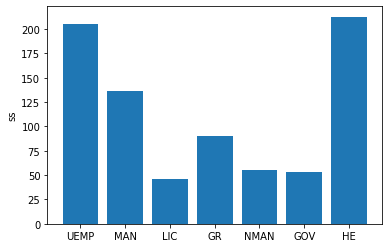

In [4]:
import matplotlib.pyplot as plt
plt.bar(['UEMP','MAN','LIC','GR','NMAN','GOV','HE'],result)
plt.ylabel('ss')
plt.show()

Therefore, we should choose LIC as it minimizes ss.

## (b) k-Nearest Neighbors

For this problem, you will be implementing the k-Nearest Neighbor (k-NN) classifier and evaluating on the `Credit Approval` (CA) dataset. It describes credit worthiness data (in this case, binary classification). (see http://archive.ics.uci.edu/ml/datasets/Credit+Approval) We have split the available data into a training set `crx.data.training` and a testing set `crx.data.testing`. These are both comma-separated text files (CSVs). 

The first step to working with the CA dataset is to process the data. In looking at the data description `crx.names`, note that there are some missing values, there exist both numerical and categorical features, and that it is a relatively balanced dataset (meaning a roughly equal number of positive and negative examples - not that you should particularly care in this case, but something you should look for in general). A great Python library for handling data like this is Pandas (https://pandas.pydata.org/pandas-docs/stable/). You can read in the data with `X = pandas.read csv(‘crx.data.training’, header=None, na values=‘?’)`. The last option tells Pandas to treat the character `?` as a missing value. 

Pandas holds data in a "dataframe". We'll deal with individual rows and columns, which Pandas calls "series". Pandas contains many convenient tools, bu the most basic you'll use is `X.iloc[i,j]`, accessing the element in the i-th row and j-th column. You can use this for both getting and setting values. You can also slice like normal Python, grabbing the i-th row with `[i,:]`. 

You can view the first 20 rows with `X.head(20)`. The last column, number 15, contains the labels. You’ll see some elements are missing, marked with `NaN`. While there are more sophisticated (and better) methods for imputing missing values, for this assign- ment, we will just use mean/mode imputation. This means that for feature 0, you should replace all of the question marks with a `b` as this is the mode, the most common value (regardless if you condition on the label or not). For real-valued features, just replace missing values with the label-conditioned mean (e.g. $μ(x_1|+)$ for instances labeled as positive).

The second aspect one should consider is normalizing features. Nominal features can be left in their given form where we define the distance to be a constant value (e.g. 1) if they are different values, and 0 if they are the same. However, it is often wise to normalize real-valued features. For the purpose of this assignment, we will use $z$-scaling, where

$$z_{i}^{(m)} \leftarrow \frac{x_{i}^{(m)}-\mu_{i}}{\sigma_{i}}$$

such that $z(m)$ indicates feature $i$ for instance $m$ (similarly $x(m)$ is the raw input), $μ_i$ is
the average value of feature $i$ over all instances, and $σ_i$ is the corresponding standard deviation over all instances.

In this notebook, include the following functions:

i. A function `impute_missing_data()` that accepts two Pandas dataframes, one training and one testing, and returns two dataframes with missing values filled in. In your report include your exact methods for each type of feature. Note that you are free to impute the values using statistics over the entire dataset (training and testing combined) or just training, but please state your method.

ii. A function normalize `features()` that accepts a training and testing dataframe and returns two dataframes with real-valued features normalized.

iii. A function `distance()` that accepts two rows of a dataframe and returns a float, the L2 distance: $D_{L2}(\mathbf{a},\mathbf{b}) = \sqrt{\sum_i (ai −bi)^2}$ . Note that we define $D_{L2}$ to have a component-wise value of 1 for categorical attribute-values that disagree and 0 if they do agree (as previously implied). Remember not to use the label column in your distance calculation!

iv. A funtion `predict()` that accepts three arguments: a training dataframe, a testing dataframe, and an integer $k$ - the number of nearest neighbors to use in predicting. This function should return a column of $+/-$ labels, one for every row in the testing data.

v. A function `accuracy()` that accepts two columns, one true labels and one predicted by your algorithm, and returns a float between 0 and 1, the fraction of labels you guessed correctly.

In your report, include accuracy results on `crx.data.testing` for at least three different values of `k`.

vi. Try your algorithm on some other data! We’ve included the “lenses” dataset (https://archive.ics.uci.edu/ml/datasets/Lenses). It has no missing values and only categorical attributes, so no need for imputation or normalization. Include accuracy results from `lenses.testing` in your report as well. 

The code you submit must be your own. If you find/use information about specific algorithms from the Web, etc., be sure to cite the source(s) clearly in your sourcecode. You are not allowed to submit code downloaded from the internet (obviously).

**Your answer:**

In [86]:
import pandas as pd
import math
X = pd.read_csv('crx.data.training', header=None, na_values='?')
Y = pd.read_csv('crx.data.testing', header=None, na_values='?')
X,Y = impute_missing_data(X,Y)
X,Y = features(X,Y)
prediction1 = predict(X,Y,3)
prediction2 = predict(X,Y,5)
prediction3 = predict(X,Y,7)
print(accuracy(prediction1,Y.iloc[:,15].tolist()))
print(accuracy(prediction2,Y.iloc[:,15].tolist()))
print(accuracy(prediction3,Y.iloc[:,15].tolist()))

33.603 5.842876984126985 3.200515873015873 4.412698412698413 164.6829268292683 2069.4841269841268
0.8913043478260869
0.8985507246376812
0.9202898550724637


In [83]:
A = pd.read_csv('lenses.training', header=None, na_values='?')
B = pd.read_csv('lenses.testing', header=None, na_values='?')
p1 = predict(A,B,3)
p2 = predict(A,B,5)
p3 = predict(A,B,2)
print(accuracy(p1,B.iloc[:,-1].tolist()))
print(accuracy(p2,B.iloc[:,-1].tolist()))
print(accuracy(p3,B.iloc[:,-1].tolist()))

0.8333333333333334
0.8333333333333334
1.0


In [68]:
def accuracy(colA,colB):
    count = 0
    for i in range(len(colA)):
        if colA[i] == colB[i]:
            count += 1
    return count/len(colA)

In [75]:
def predict(train,test,k):
    dataset = pd.concat([train, test], ignore_index=True)
    n,m = dataset.shape
    x,y = test.shape
    result = []
    for i in range(x):
        d = []
        for j in range(n):
            d.append([distance(test.iloc[i], dataset.iloc[j]),j])
        d.sort()
        d = d[:k]
        dic = {}
        for i in range(k):
            if dataset.iloc[d[i][1],-1] not in dic:
                dic[dataset.iloc[d[i][1],-1]] = 1
            else:
                dic[dataset.iloc[d[i][1],-1]] += 1
        result.append(max(dic, key=dic.get))
        
    return result


In [69]:
def distance(a,b):
    s = 0
    for i in range(len(a)-1):
        if type(a[i]) == str:
            if a[i] != b[i]:
                s+=1
        else:
            s += (a[i]-b[i])**2
    return math.sqrt(s)


In [34]:
def features(X,Y):
    n,m=X.shape
    for i in [1,2,7,10,13,14]:
        mu = np.mean(X.iloc[:,i])
        std = np.std(X.iloc[:,i])
        for j in range(n):
            X.iloc[j,i] = (X.iloc[j,i]-mu)/std
    x,y=Y.shape
    for i in [1,2,7,10,13,14]:
        mu = np.mean(Y.iloc[:,i])
        std = np.std(Y.iloc[:,i])
        for j in range(x):
            Y.iloc[j,i] = (Y.iloc[j,i]-mu)/std
    return X,Y

In [87]:
def impute_missing_data(X,Y):
    n,m = X.shape
    sum1 = [X.iloc[i,1] for i in range(n) if X.iloc[i,15] == "+" and str(X.iloc[i,1]) != "nan"]
    mu1 = np.mean(sum1)
    sum2=[X.iloc[i,2] for i in range(n) if X.iloc[i,15] == "+" and str(X.iloc[i,2]) != "nan"]
    mu2= np.mean(sum2)
    sum7 = [X.iloc[i,7] for i in range(n) if X.iloc[i,15] == "+" and str(X.iloc[i,7]) != "nan"]
    mu7= np.mean(sum7)
    sum10 = [X.iloc[i,10] for i in range(n) if X.iloc[i,15] == "+" and str(X.iloc[i,10]) != "nan"]
    mu10= np.mean(sum10)
    sum13 = [X.iloc[i,13] for i in range(n) if X.iloc[i,15] == "+" and str(X.iloc[i,13]) != "nan"]
    mu13= np.mean(sum13)
    sum14 = [X.iloc[i,14] for i in range(n) if X.iloc[i,15] == "+" and str(X.iloc[i,14]) != "nan"]
    mu14= np.mean(sum14)
    print(mu1,mu2,mu7,mu10,mu13,mu14)
    for i in range(n):
        if str(X.iloc[i,0]) == "nan":
            X.iloc[i,0] = "b"
        if str(X.iloc[i,1]) == "nan":
            X.iloc[i,1] = mu1
        if str(X.iloc[i,2]) == "nan":
            X.iloc[i,2] = mu2
        if str(X.iloc[i,3]) == "nan":
            X.iloc[i,3] = "u"
        if str(X.iloc[i,4]) == "nan":
            X.iloc[i,4] = "g"
        if str(X.iloc[i,5]) == "nan":
            X.iloc[i,5] = "c"
        if str(X.iloc[i,6]) == "nan":
            X.iloc[i,6] = "v"
        if str(X.iloc[i,7]) == "nan":
            X.iloc[i,7] = mu7
        if str(X.iloc[i,8]) == "nan":
            X.iloc[i,8] = "t"
        if str(X.iloc[i,9]) == "nan":
            X.iloc[i,9] = "f"
        if str(X.iloc[i,10]) == "nan":
            X.iloc[i,10] = mu10
        if str(X.iloc[i,11]) == "nan":
            X.iloc[i,11] = "f"
        if str(X.iloc[i,12]) == "nan":
            X.iloc[i,12] = "g"
        if str(X.iloc[i,13]) == "nan":
            X.iloc[i,13] = mu13
        if str(X.iloc[i,14]) == "nan":
            X.iloc[i,14] = mu14
    x,y = Y.shape
    sum1 = [Y.iloc[i,1] for i in range(x) if Y.iloc[i,15] == "+" and str(Y.iloc[i,1]) != "nan"]
    mu1 = sum(sum1)/len(sum1)
    sum2=[Y.iloc[i,2] for i in range(x) if Y.iloc[i,15] == "+" and str(Y.iloc[i,2]) != "nan"]
    mu2=sum(sum2)/len(sum2)
    sum7 = [Y.iloc[i,7] for i in range(x) if Y.iloc[i,15] == "+" and str(Y.iloc[i,7]) != "nan"]
    mu7=sum(sum7)/len(sum7)
    sum10 = [Y.iloc[i,10] for i in range(x) if Y.iloc[i,15] == "+" and str(Y.iloc[i,10]) != "nan"]
    mu10=sum(sum10)/len(sum10)
    sum13 = [Y.iloc[i,13] for i in range(x) if Y.iloc[i,15] == "+" and str(Y.iloc[i,13]) != "nan"]
    mu13=sum(sum13)/len(sum13)
    sum14 = [Y.iloc[i,14] for i in range(x) if Y.iloc[i,15] == "+" and str(Y.iloc[i,14]) != "nan"]
    mu14=sum(sum14)/len(sum14)
    for i in range(x):
        if str(Y.iloc[i,0]) == "nan":
            Y.iloc[i,0] = "b"
        if str(Y.iloc[i,1]) == "nan":
            Y.iloc[i,1] = mu1
        if str(Y.iloc[i,2]) == "nan":
            Y.iloc[i,2] = mu2
        if str(Y.iloc[i,3]) == "nan":
            Y.iloc[i,3] = "u"
        if str(Y.iloc[i,4]) == "nan":
            Y.iloc[i,4] = "g"
        if str(Y.iloc[i,5]) == "nan":
            Y.iloc[i,5] = "c"
        if str(Y.iloc[i,6]) == "nan":
            Y.iloc[i,6] = "v"
        if str(Y.iloc[i,7]) == "nan":
            Y.iloc[i,7] = mu7
        if str(Y.iloc[i,8]) == "nan":
            Y.iloc[i,8] = "t"
        if str(Y.iloc[i,9]) == "nan":
            Y.iloc[i,9] = "f"
        if str(Y.iloc[i,10]) == "nan":
            Y.iloc[i,10] = mu10
        if str(Y.iloc[i,11]) == "nan":
            Y.iloc[i,11] = "f"
        if str(Y.iloc[i,12]) == "nan":
            Y.iloc[i,12] = "g"
        if str(Y.iloc[i,13]) == "nan":
            Y.iloc[i,13] = mu13
        if str(Y.iloc[i,14]) == "nan":
            Y.iloc[i,14] = mu14
        
    return X,Y

Report:\
$\text{Feature 0: replace all the nan with b}$\
$\text{Feature 1: repalce all the nan with \mu(x|+) = 33.603}$\ 
$\text{Feature 2: repalce all the nan with \mu(x|+) = 5.84}$\
$\text{Feature 3: replace all the nan with u}$\
$\text{Feature 4: replace all the nan with g}$\
$\text{Feature 5: replace all the nan with c}$\
$\text{Feature 6: replace all the nan with v}$\
$\text{Feature 7: repalce all the nan with \mu(x|+) = 3.2}$\
$\text{Feature 8: replace all the nan with t}$\
$\text{Feature 9: replace all the nan with f}$\
$\text{Feature 10: repalce all the nan with \mu(x|+) = 4.41}$\
$\text{Feature 11: replace all the nan with f}$\
$\text{Feature 12: replace all the nan with g}$\
$\text{Feature 13: repalce all the nan with \mu(x|+) = 164.68}$\
$\text{Feature 14: repalce all the nan with \mu(x|+) = 2069.5}$\
$\text{For crx.data.testing, I tried k = 3, where accuracy is 0.891, k = 5. where accuracy is 0.898, k = 7 where accuracy is 0.92.}$\
$\text{For lenses.testing, I tried k = 2, where accuracy is 1, k = 3. where accuracy is 0.833, k = 5 where accuracy is 0.83.}$\







